# Introduction

After some trials on FMA dataset, we will now try to apply what we learned on another dataset which is a Kaggle Competition. In this one, we have an unbalanced dataset of 41 labels. Durations are also very differents which will create other difficulties mainly if we zant to use features like MFCC or STFT. 

In this first one, we will extract feature as it was with FMA dataset. The good point of this solution is to not have to take care about duration as we use stats.

# Exploration

In [1]:
import os

from tqdm import tqdm
import numpy as np
from scipy import stats
import pandas as pd
import librosa
import glob
import utils
import tqdm
import seaborn as sns
import multiprocessing
import warnings
from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("train.csv", index_col=0)
df.head()

,label,manually_verified
fname,,
00044347.wav,Hi-hat,0
001ca53d.wav,Saxophone,1
002d256b.wav,Trumpet,0
0033e230.wav,Glockenspiel,1
00353774.wav,Cello,1


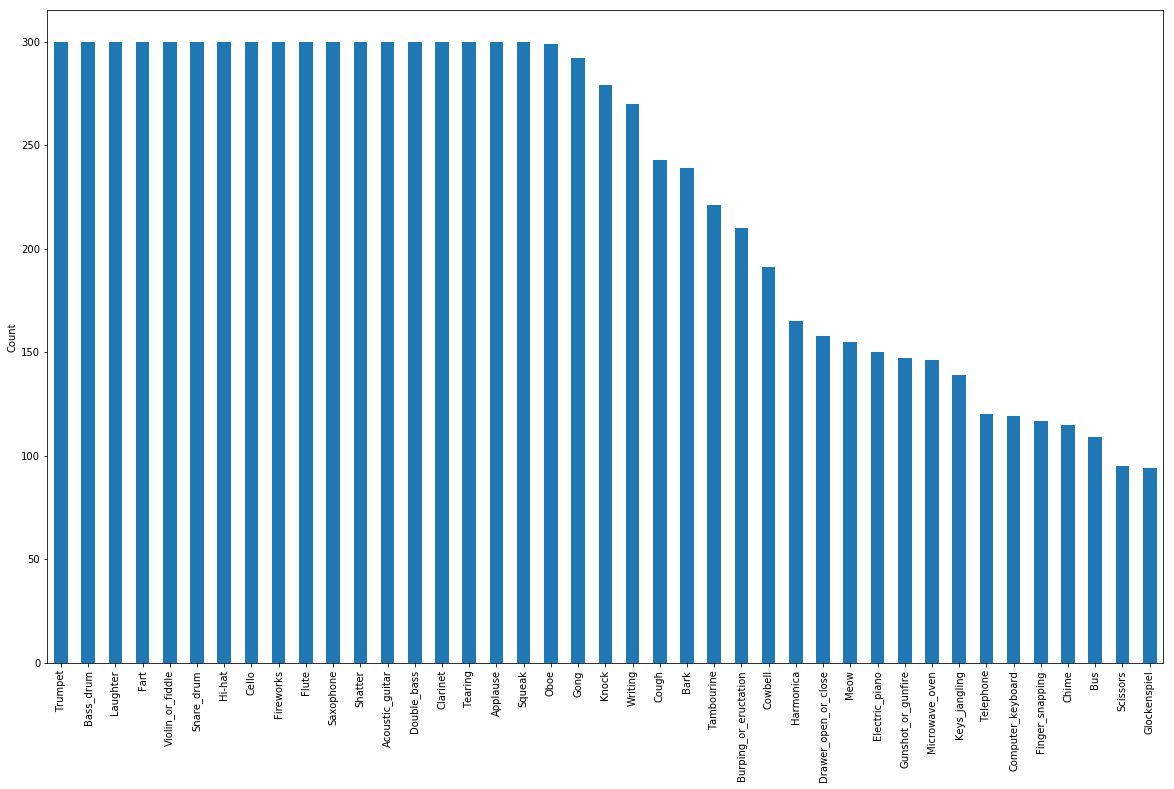

In [3]:
plt.figure(figsize=(20,12))
df.label.value_counts().plot('bar')
plt.ylabel("Count")
plt.show()

In [6]:
df["duration"] = 0

for song in tqdm.tqdm(glob.glob("F:/data/kaggle/audio_train/*.wav")):
    tid = os.path.basename(song)
    x, sr = librosa.load(song, sr=None, mono=True)
    df.loc[tid, "duration"] = len(x)/sr

100%|█████████████████████████████████████████████████████████████████████████████| 9473/9473 [00:39<00:00, 238.86it/s]


In [7]:
df.head()

,label,manually_verified,duration
fname,,,
00044347.wav,Hi-hat,0,14.00
001ca53d.wav,Saxophone,1,10.32
002d256b.wav,Trumpet,0,0.44
0033e230.wav,Glockenspiel,1,8.00
00353774.wav,Cello,1,4.52


In [8]:
df.to_csv("train_with_time.csv")

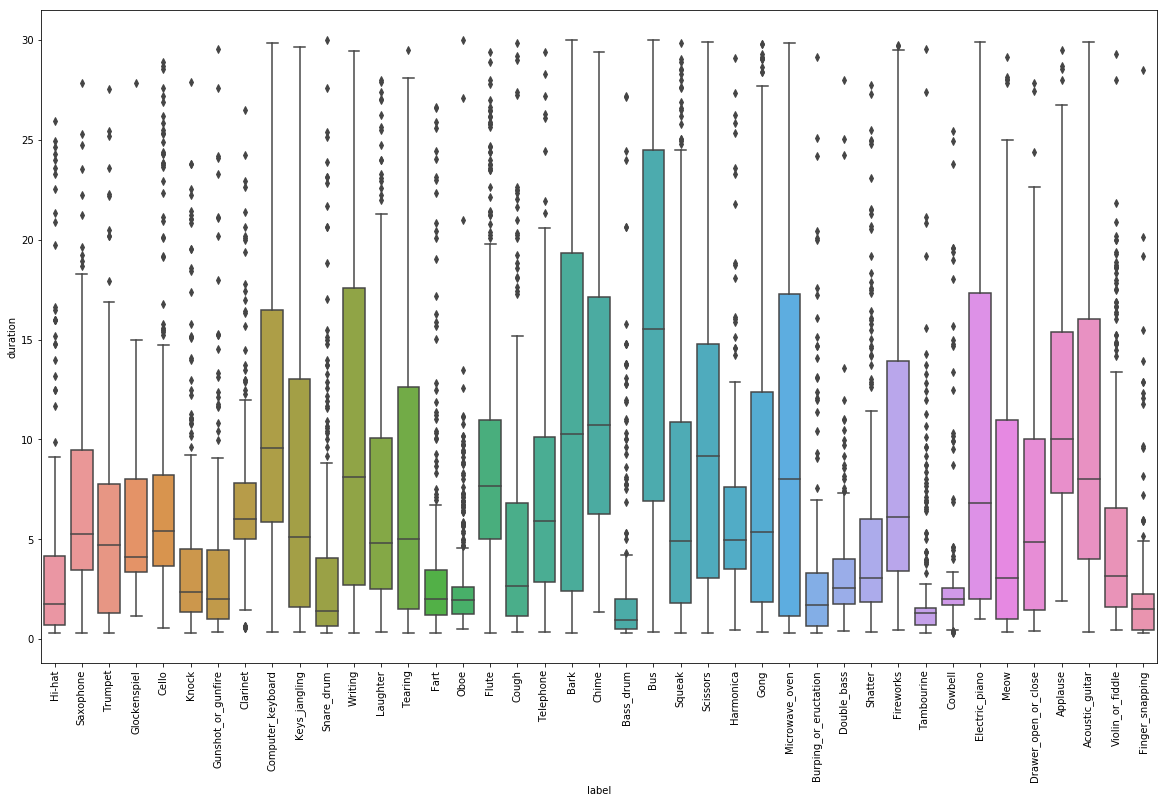

In [16]:
plt.figure(figsize = (20,12))
g = sns.boxplot(y="duration", x="label", data=df)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=90)
plt.show()

# Extraction

Now let's extract features. To do so, we will reuse code from <a href="https://github.com/mdeff/fma">FMA</a> analysis. I just removed some asserts and modify things to avoid errors (mainly with too short audio file. 

In [4]:
def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    return columns.sort_values()

In [5]:
def compute_features_by_song(path, tid):

    features = pd.Series(index=columns(), dtype=np.float32, name=tid)

    # Catch warnings as exceptions (audioread leaks file descriptors).
    warnings.filterwarnings('error', module='librosa')

    def feature_stats(name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)

    try:
        x, sr = librosa.load(path, sr=None, mono=True)  # kaiser_fast

        f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
        feature_stats('zcr', f)

        cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12, n_bins=7*12))

        f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
        feature_stats('chroma_cqt', f)
        f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
        feature_stats('chroma_cens', f)
        f = librosa.feature.tonnetz(chroma=f)
        feature_stats('tonnetz', f)

        del cqt
        stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
        del x

        f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12, tuning=0) # was stft**2
        feature_stats('chroma_stft', f)

        f = librosa.feature.rmse(S=stft)
        feature_stats('rmse', f)

        f = librosa.feature.spectral_centroid(S=stft)
        feature_stats('spectral_centroid', f)
        f = librosa.feature.spectral_bandwidth(S=stft)
        feature_stats('spectral_bandwidth', f)
        f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
        feature_stats('spectral_contrast', f)
        f = librosa.feature.spectral_rolloff(S=stft)
        feature_stats('spectral_rolloff', f)

        mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
        del stft
        f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
        feature_stats('mfcc', f)

    except Exception as e:
        print('{}: {}'.format(tid, repr(e)))

    return features

In [6]:
def save(features, ndigits, train):

    features.sort_index(axis=0, inplace=True)
    features.sort_index(axis=1, inplace=True)

    features.to_csv('features_{}.csv'.format(train), float_format='%.{}e'.format(ndigits))

In [ ]:
# import glob

# tracks = pd.read_csv("train.csv", index_col=0)
# try:
#     features = tracks = pd.read_csv("features_train.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)
# except:
#     features = pd.DataFrame(index=tracks.index,
#                             columns=columns(), dtype=np.float32)

# tids = tracks.index.values

# for i, song in enumerate(glob.glob("F:/data/kaggle/audio_train/*.wav")):
#     tid = os.path.basename(song)
#     if features.loc[tid].isnull().sum() > 250:
#         it = compute_features_by_song(song, tid)

#         features.loc[it.name] = it

#         if i % 100 == 0:
#             save(features, 10, "train")
#     else:
#         print(tid, "pass")


# save(features, 10, "train")


# arr = os.listdir("F:/data/kaggle/audio_test/")
# features = pd.DataFrame(index=arr,
#                         columns=columns(), dtype=np.float32)

# for i, song in enumerate(glob.glob("F:/data/kaggle/audio_test/*.wav")):
#     tid = os.path.basename(song)
#     if features.loc[tid].isnull().sum() > 250:
#         it = compute_features_by_song(song, tid)

#         features.loc[it.name] = it

#         if i % 100 == 0:
#             save(features, 10, "test")

# save(features, 10, "test")

This has been extracted outside this notebook as it requires a lot of time (aroudn 40 min for each datasets). In addition, we will add the duration

# Data Preparation

In [7]:
features_train = pd.read_csv("features_train.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)
features_train.head()

feature      chroma_cens                                                    \
statistics      kurtosis                                                     
number                01        02        03        04        05        06   
fname                                                                        
00044347.wav   -0.369576  1.055880  0.201146 -0.266218  0.481468  3.404086   
001ca53d.wav    2.175135 -0.599357 -0.822873 -0.350541  1.821276  1.258501   
002d256b.wav   -1.506056 -1.252940 -1.407562 -1.571398 -1.196982 -1.126037   
0033e230.wav   -1.614346 -1.346174 -1.561703 -1.547438 -1.596021 -1.697389   
00353774.wav    1.651032 -0.332861 -0.180722 -0.207577 -0.356005  0.841218   

feature                                                 ...      tonnetz  \
statistics                                              ...          std   
number              07        08        09        10    ...           04   
fname                                                   ...                
00044347.wav  0.992444 -0.114670 -0.339559 -0.250056    ...     0.041439   
001ca53d.wav -1.217571 -1.723796 -1.629945 -0.565814    ...     0.203927   
002d256b.wav -1.568913 -1.306993 -1.533478 -1.115415    ...     0.057760   
0033e230.wav -1.631284 -1.617585 -1.625785 -1.515693    ...     0.187971   
00353774.wav -0.519981  0.130616  4.276734  0.477776    ...     0.090757   

feature                                 zcr                                \
statistics                         kurtosis       max      mean    median   
number              05        06         01        01        01        01   
fname                                                                       
00044347.wav  0.015673  0.017553   3.711630  0.511719  0.157470  0.118164   
001ca53d.wav  0.023625  0.031475  30.205433  0.145996  0.021231  0.018066   
002d256b.wav  0.039681  0.008625   1.722913  0.133301  0.057926  0.056152   
0033e230.wav  0.017533  0.025248  -1.671211  0.529785  0.217430  0.049805   
00353774.wav  0.025807  0.010812  28.114944  0.154297  0.035015  0.034668   

feature                                     
statistics         min      skew       std  
number              01        01        01  
fname                                       
00044347.wav  0.071289  2.018521  0.098130  
001ca53d.wav  0.008789  4.477385  0.012380  
002d256b.wav  0.014160  1.131510  0.025934  
0033e230.wav  0.047363  0.534290  0.213069  
00353774.wav  0.000000  3.124701  0.014186  

[5 rows x 518 columns]

In [8]:
features_test = pd.read_csv("features_test.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)
features_test.head()

feature      chroma_cens                                                    \
statistics      kurtosis                                                     
number                01        02        03        04        05        06   
00063640.wav   -0.244638 -1.237185  0.763498 -1.503968 -0.617607 -0.397222   
0013a1db.wav   -0.109881 -1.092749 -1.399254 -1.220698 -1.034245 -1.055509   
002bb878.wav   -0.752191 -1.234659 -1.322605  0.567769 -1.377244 -0.881712   
002d392d.wav   -1.293045 -1.435214 -1.305916 -1.536875 -1.637259 -1.175508   
00326aa9.wav   -1.312671 -0.277192 -1.217986  0.539502 -1.542407 -1.131608   

feature                                                 ...      tonnetz  \
statistics                                              ...          std   
number              07        08        09        10    ...           04   
00063640.wav -0.139802 -0.167749 -0.147579 -0.497323    ...     0.029292   
0013a1db.wav -0.788511 -1.312285 -0.380233 -0.417627    ...     0.127094   
002bb878.wav -0.242451 -0.103660  0.826157 -1.087463    ...     0.029367   
002d392d.wav -0.347901 -0.563668 -1.036180 -1.534855    ...     0.010011   
00326aa9.wav -0.410958 -1.036260 -1.806741 -1.600477    ...     0.129163   

feature                                 zcr                                \
statistics                         kurtosis       max      mean    median   
number              05        06         01        01        01        01   
00063640.wav  0.008349  0.015237  -0.451336  0.513672  0.364097  0.414551   
0013a1db.wav  0.021076  0.007583  -0.870766  0.394043  0.136285  0.053711   
002bb878.wav  0.006547  0.015580  23.189625  0.074707  0.007892  0.003906   
002d392d.wav  0.000410  0.017953  11.348858  0.011719  0.003640  0.003418   
00326aa9.wav  0.022725  0.048103   1.023942  0.104980  0.054245  0.060059   

feature                                     
statistics         min      skew       std  
number              01        01        01  
00063640.wav  0.055664 -0.806147  0.130271  
0013a1db.wav  0.027344  0.969664  0.133629  
002bb878.wav  0.001953  4.338827  0.010702  
002d392d.wav  0.001953  3.395075  0.001869  
00326aa9.wav  0.003418 -0.952933  0.018189  

[5 rows x 518 columns]

In [9]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9473 entries, 00044347.wav to fff81f55.wav
Columns: 518 entries, (chroma_cens, kurtosis, 01) to (zcr, std, 01)
dtypes: float64(518)
memory usage: 37.5+ MB


In [10]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9400 entries, 00063640.wav to fff8d22d.wav
Columns: 518 entries, (chroma_cens, kurtosis, 01) to (zcr, std, 01)
dtypes: float64(518)
memory usage: 37.2+ MB


In the test set 3 song are corrupted from the archive. As a result, we will remove them and after the model we will add 3 random guess for those 3 song to have the correct number of line

In [11]:
for col in features_test:
    print(col, features_test[col].isnull().sum())

('chroma_cens', 'kurtosis', '01') 3
('chroma_cens', 'kurtosis', '02') 3
('chroma_cens', 'kurtosis', '03') 3
('chroma_cens', 'kurtosis', '04') 3
('chroma_cens', 'kurtosis', '05') 3
('chroma_cens', 'kurtosis', '06') 3
('chroma_cens', 'kurtosis', '07') 3
('chroma_cens', 'kurtosis', '08') 3
('chroma_cens', 'kurtosis', '09') 3
('chroma_cens', 'kurtosis', '10') 3
('chroma_cens', 'kurtosis', '11') 3
('chroma_cens', 'kurtosis', '12') 3
('chroma_cens', 'max', '01') 3
('chroma_cens', 'max', '02') 3
('chroma_cens', 'max', '03') 3
('chroma_cens', 'max', '04') 3
('chroma_cens', 'max', '05') 3
('chroma_cens', 'max', '06') 3
('chroma_cens', 'max', '07') 3
('chroma_cens', 'max', '08') 3
('chroma_cens', 'max', '09') 3
('chroma_cens', 'max', '10') 3
('chroma_cens', 'max', '11') 3
('chroma_cens', 'max', '12') 3
('chroma_cens', 'mean', '01') 3
('chroma_cens', 'mean', '02') 3
('chroma_cens', 'mean', '03') 3
('chroma_cens', 'mean', '04') 3
('chroma_cens', 'mean', '05') 3
('chroma_cens', 'mean', '06') 3
('ch

('mfcc', 'kurtosis', '04') 3
('mfcc', 'kurtosis', '05') 3
('mfcc', 'kurtosis', '06') 3
('mfcc', 'kurtosis', '07') 3
('mfcc', 'kurtosis', '08') 3
('mfcc', 'kurtosis', '09') 3
('mfcc', 'kurtosis', '10') 3
('mfcc', 'kurtosis', '11') 3
('mfcc', 'kurtosis', '12') 3
('mfcc', 'kurtosis', '13') 3
('mfcc', 'kurtosis', '14') 3
('mfcc', 'kurtosis', '15') 3
('mfcc', 'kurtosis', '16') 3
('mfcc', 'kurtosis', '17') 3
('mfcc', 'kurtosis', '18') 3
('mfcc', 'kurtosis', '19') 3
('mfcc', 'kurtosis', '20') 3
('mfcc', 'max', '01') 3
('mfcc', 'max', '02') 3
('mfcc', 'max', '03') 3
('mfcc', 'max', '04') 3
('mfcc', 'max', '05') 3
('mfcc', 'max', '06') 3
('mfcc', 'max', '07') 3
('mfcc', 'max', '08') 3
('mfcc', 'max', '09') 3
('mfcc', 'max', '10') 3
('mfcc', 'max', '11') 3
('mfcc', 'max', '12') 3
('mfcc', 'max', '13') 3
('mfcc', 'max', '14') 3
('mfcc', 'max', '15') 3
('mfcc', 'max', '16') 3
('mfcc', 'max', '17') 3
('mfcc', 'max', '18') 3
('mfcc', 'max', '19') 3
('mfcc', 'max', '20') 3
('mfcc', 'mean', '01') 3
('

In [12]:
a = ["F:/data/kaggle/audio_test/"+x for x in features_test[features_test[('spectral_centroid', 'max', '01')].isnull()].index.values]
for song in a:
    tid = os.path.basename(song)
    toto = compute_features_by_song(song, tid)
    print(tid, toto.isnull().sum())

0b0427e2.wav: IndexError('index 0 is out of bounds for axis 0 with size 0',)
0b0427e2.wav 518
6ea0099f.wav: IndexError('index 0 is out of bounds for axis 0 with size 0',)
6ea0099f.wav 518
b39975f5.wav: IndexError('index 0 is out of bounds for axis 0 with size 0',)
b39975f5.wav 518


Now let's add duration to both dataset (for the train we may use a join too). In addition, I add the duration afterward and not directy during the function just beacuse I git this idea afterward and I didn't want to spend 1h30 to re-generate both datasets

In [13]:
features_train[("duration", "duration", "duration")] = 0

for song in tqdm.tqdm(glob.glob("F:/data/kaggle/audio_train/*.wav")):
    tid = os.path.basename(song)
    x, sr = librosa.load(song, sr=None, mono=True)
    features_train.loc[tid, ("duration", "duration", "duration")] = len(x)/sr

100%|█████████████████████████████████████████████████████████████████████████████| 9473/9473 [00:39<00:00, 240.25it/s]


In [15]:
features_test[("duration", "duration", "duration")] = 0

for song in tqdm.tqdm(glob.glob("F:/data/kaggle/audio_test/*.wav")):
    tid = os.path.basename(song)
    try:
        x, sr = librosa.load(song, sr=None, mono=True)
        features_test.loc[tid, ("duration", "duration", "duration")] = len(x)/sr
    except:
        pass # means taht duration will remain 0

100%|██████████████████████████████████████████████████████████████████████████████| 9400/9400 [03:45<00:00, 41.64it/s]


In [21]:
features_test.head()

feature      chroma_cens                                                    \
statistics      kurtosis                                                     
number                01        02        03        04        05        06   
00063640.wav   -0.244638 -1.237185  0.763498 -1.503968 -0.617607 -0.397222   
0013a1db.wav   -0.109881 -1.092749 -1.399254 -1.220698 -1.034245 -1.055509   
002bb878.wav   -0.752191 -1.234659 -1.322605  0.567769 -1.377244 -0.881712   
002d392d.wav   -1.293045 -1.435214 -1.305916 -1.536875 -1.637259 -1.175508   
00326aa9.wav   -1.312671 -0.277192 -1.217986  0.539502 -1.542407 -1.131608   

feature                                                 ...      tonnetz  \
statistics                                              ...          std   
number              07        08        09        10    ...           04   
00063640.wav -0.139802 -0.167749 -0.147579 -0.497323    ...     0.029292   
0013a1db.wav -0.788511 -1.312285 -0.380233 -0.417627    ...     0.127094   
002bb878.wav -0.242451 -0.103660  0.826157 -1.087463    ...     0.029367   
002d392d.wav -0.347901 -0.563668 -1.036180 -1.534855    ...     0.010011   
00326aa9.wav -0.410958 -1.036260 -1.806741 -1.600477    ...     0.129163   

feature                                 zcr                                \
statistics                         kurtosis       max      mean    median   
number              05        06         01        01        01        01   
00063640.wav  0.008349  0.015237  -0.451336  0.513672  0.364097  0.414551   
0013a1db.wav  0.021076  0.007583  -0.870766  0.394043  0.136285  0.053711   
002bb878.wav  0.006547  0.015580  23.189625  0.074707  0.007892  0.003906   
002d392d.wav  0.000410  0.017953  11.348858  0.011719  0.003640  0.003418   
00326aa9.wav  0.022725  0.048103   1.023942  0.104980  0.054245  0.060059   

feature                                     
statistics         min      skew       std  
number              01        01        01  
00063640.wav  0.055664 -0.806147  0.130271  
0013a1db.wav  0.027344  0.969664  0.133629  
002bb878.wav  0.001953  4.338827  0.010702  
002d392d.wav  0.001953  3.395075  0.001869  
00326aa9.wav  0.003418 -0.952933  0.018189  

[5 rows x 519 columns]

In [17]:
save(features_train, 10, "train_with_time")
save(features_test, 10, "test_with_time")

# Models

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [18]:
features_train = pd.read_csv("features_train_with_time.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)
features_train.head()

feature      chroma_cens                                                    \
statistics      kurtosis                                                     
number                01        02        03        04        05        06   
fname                                                                        
00044347.wav   -0.369576  1.055880  0.201146 -0.266218  0.481468  3.404086   
001ca53d.wav    2.175135 -0.599357 -0.822873 -0.350541  1.821276  1.258501   
002d256b.wav   -1.506056 -1.252940 -1.407562 -1.571398 -1.196982 -1.126037   
0033e230.wav   -1.614346 -1.346174 -1.561703 -1.547438 -1.596021 -1.697389   
00353774.wav    1.651032 -0.332861 -0.180722 -0.207577 -0.356005  0.841218   

feature                                                 ...      tonnetz  \
statistics                                              ...          std   
number              07        08        09        10    ...           04   
fname                                                   ...                
00044347.wav  0.992444 -0.114670 -0.339559 -0.250056    ...     0.041439   
001ca53d.wav -1.217571 -1.723796 -1.629945 -0.565814    ...     0.203927   
002d256b.wav -1.568913 -1.306993 -1.533478 -1.115415    ...     0.057760   
0033e230.wav -1.631284 -1.617585 -1.625785 -1.515693    ...     0.187971   
00353774.wav -0.519981  0.130616  4.276734  0.477776    ...     0.090757   

feature                                 zcr                                \
statistics                         kurtosis       max      mean    median   
number              05        06         01        01        01        01   
fname                                                                       
00044347.wav  0.015673  0.017553   3.711630  0.511719  0.157470  0.118164   
001ca53d.wav  0.023625  0.031475  30.205433  0.145996  0.021231  0.018066   
002d256b.wav  0.039681  0.008625   1.722913  0.133301  0.057926  0.056152   
0033e230.wav  0.017533  0.025248  -1.671211  0.529785  0.217430  0.049805   
00353774.wav  0.025807  0.010812  28.114944  0.154297  0.035015  0.034668   

feature                                     
statistics         min      skew       std  
number              01        01        01  
fname                                       
00044347.wav  0.071289  2.018521  0.098130  
001ca53d.wav  0.008789  4.477385  0.012380  
002d256b.wav  0.014160  1.131510  0.025934  
0033e230.wav  0.047363  0.534290  0.213069  
00353774.wav  0.000000  3.124701  0.014186  

[5 rows x 519 columns]

In [28]:
features_test = pd.read_csv("features_test_with_time.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)
features_test.head()

feature      chroma_cens                                                    \
statistics      kurtosis                                                     
number                01        02        03        04        05        06   
00063640.wav   -0.244638 -1.237185  0.763498 -1.503968 -0.617607 -0.397222   
0013a1db.wav   -0.109881 -1.092749 -1.399254 -1.220698 -1.034245 -1.055509   
002bb878.wav   -0.752191 -1.234659 -1.322605  0.567769 -1.377244 -0.881712   
002d392d.wav   -1.293045 -1.435214 -1.305916 -1.536875 -1.637259 -1.175508   
00326aa9.wav   -1.312671 -0.277192 -1.217986  0.539502 -1.542407 -1.131608   

feature                                                 ...      tonnetz  \
statistics                                              ...          std   
number              07        08        09        10    ...           04   
00063640.wav -0.139802 -0.167749 -0.147579 -0.497323    ...     0.029292   
0013a1db.wav -0.788511 -1.312285 -0.380233 -0.417627    ...     0.127094   
002bb878.wav -0.242451 -0.103660  0.826157 -1.087463    ...     0.029367   
002d392d.wav -0.347901 -0.563668 -1.036180 -1.534855    ...     0.010011   
00326aa9.wav -0.410958 -1.036260 -1.806741 -1.600477    ...     0.129163   

feature                                 zcr                                \
statistics                         kurtosis       max      mean    median   
number              05        06         01        01        01        01   
00063640.wav  0.008349  0.015237  -0.451336  0.513672  0.364097  0.414551   
0013a1db.wav  0.021076  0.007583  -0.870766  0.394043  0.136285  0.053711   
002bb878.wav  0.006547  0.015580  23.189625  0.074707  0.007892  0.003906   
002d392d.wav  0.000410  0.017953  11.348858  0.011719  0.003640  0.003418   
00326aa9.wav  0.022725  0.048103   1.023942  0.104980  0.054245  0.060059   

feature                                     
statistics         min      skew       std  
number              01        01        01  
00063640.wav  0.055664 -0.806147  0.130271  
0013a1db.wav  0.027344  0.969664  0.133629  
002bb878.wav  0.001953  4.338827  0.010702  
002d392d.wav  0.001953  3.395075  0.001869  
00326aa9.wav  0.003418 -0.952933  0.018189  

[5 rows x 519 columns]

In [29]:
features_test = features_test.dropna(axis=0)

In [30]:
X = features_train.values
X_val = features_test.values
y = df.label.values

In [31]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

In [32]:
pca = PCA(n_components=0.99)
new_X = pca.fit_transform(X)
new_X_val = pca.transform(X_val)

In [34]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()
y_enc = enc.fit_transform(y.reshape(-1, 1))

In [35]:
X_train, X_test, y_train, y_test, y_enc_train, y_enc_test = train_test_split(new_X, y, y_enc, test_size=0.20, random_state=42)

## Classic models

In [36]:
clf = LinearSVC(multi_class = "crammer_singer")

clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8573502243335973
0.6812664907651715


In [37]:
clf = LogisticRegressionCV(multi_class="multinomial")

clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8416468725257323
0.6770448548812665


In [38]:
for depth in range(5, 12):
    clf = RandomForestClassifier(n_estimators = 50, max_depth=depth)
    clf.fit(X_train, y_train)
    print("\nDepth:", depth)
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))


Depth: 5
0.45975191343362365
0.3762532981530343

Depth: 6
0.5603061493797836
0.41952506596306066

Depth: 7
0.6278701504354711
0.4395778364116095

Depth: 8
0.7327790973871734
0.46226912928759895

Depth: 9
0.7944048561625758
0.48232189973614775

Depth: 10
0.8494325679598839
0.49815303430079155

Depth: 11
0.9192399049881235
0.5102902374670185


In [39]:
for depth in range(5, 12):
    clf = ExtraTreesClassifier(n_estimators = 50, max_depth=depth)
    clf.fit(X_train, y_train)
    print("\nDepth:", depth)
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))


Depth: 5
0.4998680390604381
0.39683377308707124

Depth: 6
0.5740300870942201
0.40474934036939314

Depth: 7
0.6430456584850884
0.42321899736147756

Depth: 8
0.7337028239641066
0.45593667546174144

Depth: 9
0.8143309580364212
0.46121372031662267

Depth: 10
0.850488255476379
0.46754617414248023

Depth: 11
0.9070994985484296
0.48865435356200526


In [109]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from keras.layers import BatchNormalization

In [110]:
early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

def swish(x):
    return x*K.sigmoid(x)

get_custom_objects().update({'custom_activation': swish})

In [120]:
K.clear_session()

model = Sequential()
model.add(Dense(192, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(96, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(y_enc_train.shape[1], activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 192)               50496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 192)               768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               24704     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                12384     
__________

In [121]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=["categorical_crossentropy", "accuracy"])

In [122]:
history1 = model.fit(X_train, y_enc_train, 
                    epochs=100, 
                    batch_size=100, 
                    verbose=2, 
                    validation_data=(X_test, y_enc_test),
                    callbacks=[early])

Train on 7578 samples, validate on 1895 samples
Epoch 1/100
 - 1s - loss: 3.6379 - categorical_crossentropy: 3.6379 - acc: 0.1103 - val_loss: 2.6006 - val_categorical_crossentropy: 2.6006 - val_acc: 0.3018
Epoch 2/100
 - 1s - loss: 2.7616 - categorical_crossentropy: 2.7616 - acc: 0.2498 - val_loss: 2.1851 - val_categorical_crossentropy: 2.1851 - val_acc: 0.4000
Epoch 3/100
 - 1s - loss: 2.4088 - categorical_crossentropy: 2.4088 - acc: 0.3291 - val_loss: 1.9322 - val_categorical_crossentropy: 1.9322 - val_acc: 0.4728
Epoch 4/100
 - 1s - loss: 2.1348 - categorical_crossentropy: 2.1348 - acc: 0.3998 - val_loss: 1.7464 - val_categorical_crossentropy: 1.7464 - val_acc: 0.5272
Epoch 5/100
 - 1s - loss: 1.9544 - categorical_crossentropy: 1.9544 - acc: 0.4493 - val_loss: 1.6079 - val_categorical_crossentropy: 1.6079 - val_acc: 0.5736
Epoch 6/100
 - 1s - loss: 1.7993 - categorical_crossentropy: 1.7993 - acc: 0.4938 - val_loss: 1.4991 - val_categorical_crossentropy: 1.4991 - val_acc: 0.6021
Epoc

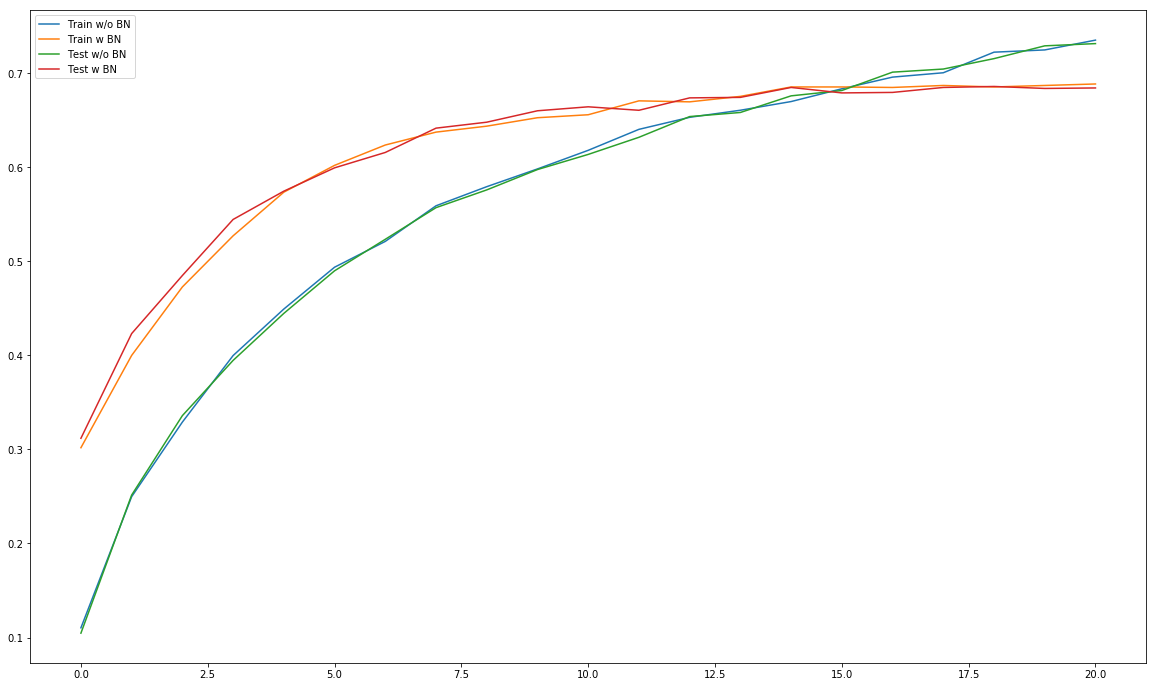

In [124]:
plt.figure(figsize = (20, 12))
plt.plot(history1.history["acc"], label="Train w/o BN")
plt.plot(history1.history["val_acc"], label="Train w BN")
plt.plot(history2.history["acc"], label="Test w/o BN")
plt.plot(history2.history["val_acc"], label="Test w BN")
plt.legend()
plt.show()

After several trials with different topology, dropout, activation with and w/o Batch Norlization, we reach a kind of limit with this simple model to around 69 % accuracy. Now we can predict classes on the test dataset and then, based on the probability, we may predict more than 1 class 

In [125]:
y_pred = model.predict(new_X_val)

In [126]:
y_pred

array([[9.31317118e-06, 9.28571899e-05, 2.17406578e-05, ...,
        4.37812196e-05, 9.93150934e-07, 1.83846557e-03],
       [1.76659603e-06, 2.82173391e-06, 1.15223447e-05, ...,
        1.03926439e-04, 1.05663380e-02, 7.07007416e-07],
       [2.05688484e-05, 9.75400781e-06, 1.78894697e-05, ...,
        1.05161253e-05, 1.25301585e-06, 1.07402157e-04],
       ...,
       [4.00597462e-04, 6.12106192e-07, 6.96280438e-08, ...,
        1.34782097e-03, 7.76872277e-01, 1.65056117e-05],
       [7.36598395e-06, 1.09626676e-07, 1.00541797e-06, ...,
        8.17781029e-07, 5.57596032e-08, 1.58217131e-06],
       [3.37323727e-04, 2.05594048e-01, 1.17623922e-03, ...,
        2.01156639e-04, 8.73125903e-03, 2.45847576e-03]], dtype=float32)

In [127]:
def get_pred(x):
    x = np.expand_dims(x, 0)
    if x.max() < 0.4:
        maxi = x.max()
        pred = enc.inverse_transform((x == maxi).astype(int))
    else:
        pred = enc.inverse_transform((x >= 0.4).astype(int))
    return " ".join(pred[0])

In [128]:
output = features_test.reset_index()[["index"]]
output.columns = ["fname"]
output["label"] = [ get_pred(row) for row in y_pred]
output = output.set_index("fname")

In [136]:
output.head()

,label
fname,
00063640.wav,Shatter
0013a1db.wav,Flute
002bb878.wav,Bass_drum
002d392d.wav,Bass_drum
00326aa9.wav,Oboe


Now we have our prediction. The only point is that we removed 3 lines of bugged audio. We have now to add them with a random class

In [130]:
control = pd.read_csv("features_test.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0).reset_index()[["index"]]
control.columns = ["fname"]
control = control.set_index("fname")

In [131]:
output_2 = output.join(control, how="outer")

In [133]:
output_2 = output_2.fillna('Glockenspiel')

In [134]:
output_2.head()

,label
fname,
00063640.wav,Shatter
0013a1db.wav,Flute
002bb878.wav,Bass_drum
002d392d.wav,Bass_drum
00326aa9.wav,Oboe


In [135]:
output_2.to_csv("result.csv")

# Conclusion

The result on Kaggle for this model is 74.4% which is not so bad but far from the top. This can be explained mainly because we sum up features by only few stats due to time variation. As a result, we lose a lot of inforamtions probably usefull for some classes. 

There is few possibilities to improve this model a bit. With data augmentation, we can create more datas by adding noise. In addition, this may be a solution to oversample some classes to balance the dataset... The prediction from our model is not so far better than more simple models. As a result, we may create a bagging of classifier to be more accurate. 